# 3. Arhitektura Modela i Pristup Treniranju

## Multi-output klasifikacija sa ResNet-50

---

Nakon pripreme dataset-a, sledeći korak je dizajn modela koji će moći da predvidi sva tri izlaza: make, model i year.

In [1]:
# Import biblioteka
import sys
from pathlib import Path
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Dodaj src u path
current_dir = Path.cwd()
project_root = current_dir if current_dir.name != 'notebooks' else current_dir.parent
src_path = project_root / "src"
sys.path.insert(0, str(src_path))

# Import naših modula
from model import MultiOutputCarClassifier, MultiOutputLoss, calculate_class_weights

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

### Koncept Multi-output klasifikacije

Za razliku od standardne klasifikacije koja predviđa jednu klasu, naš problem zahteva **istovremeno predviđanje tri različita izlaza**:

- **Make**: Proizvođač automobila (BMW, AUDI, MERCEDES, ...)
- **Model**: Model automobila (3_SERIES, A4, C_CLASS, ...)
- **Year**: Decenija proizvodnje (1960s, 1970s, ..., 2020s)

Ovo se rešava arhitekturom sa **zajedničkim backbone-om** i **odvojenim head-ovima** za svaki izlaz.

### Arhitektura MultiOutputCarClassifier

Na osnovu implementacije u `src/model.py`, model se sastoji od tri glavna dela:

#### 1. Backbone (ResNet-50)
- **Pretrained weights**: `ResNet50_Weights.IMAGENET1K_V1` kada je `pretrained=True`
- **Feature dimension**: 2048D (iz `self.backbone.fc.in_features`)
- **Modifikacija**: Poslednji FC layer se zamenjuje sa `nn.Identity()` 
- **Alternativa**: Podržava i EfficientNet-B3 kao backbone option

#### 2. Classification Heads
Svaki head ima istu strukturu ali različite veličine na osnovu broja klasa:

- **Make Head**: `2048 → 512 → num_makes`
  - `nn.Sequential(Dropout(0.5), Linear(2048, 512), ReLU(), Dropout(0.3), Linear(512, num_makes))`
  
- **Model Head**: `2048 → 1024 → num_models`  
  - Najveći hidden layer (1024) zbog najvećeg broja klasa
  - Ista dropout struktura (0.5 → 0.3)
  
- **Year Head**: `2048 → 256 → num_years`
  - Najmanji hidden layer (256) za najmanje klasa
  - Konzistentna regularizacija

#### 3. MultiOutputLoss
Kombinovana loss funkcija definisana u `MultiOutputLoss` klasi:
- **Komponente**: Tri odvojene `nn.CrossEntropyLoss` instance
- **Weights**: Podešavaju važnost svakog izlaza (`make_weight`, `model_weight`, `year_weight`)
- **Class weights**: Opciono `class_weights` tensor za svaki izlaz
- **Formula**: `total_loss = make_weight × make_loss + model_weight × model_loss + year_weight × year_loss`

#### 4. Transfer Learning podrška
Model ima ugrađene metode za kontrolu treniranja:
- `freeze_backbone()`: Postavlja `requires_grad=False` za backbone parametre
- `unfreeze_backbone()`: Omogućava treniranje backbone-a
- `get_trainable_parameters()`: Vraća odvojene liste backbone i head parametara"

In [ ]:
# Kreiranje modela - prikaz koda iz src/model.py

# Multi-output heads definicija
make_head = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 81)  # num_makes
)

model_head = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024, 1358)  # num_models
)

year_head = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(2048, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 12)  # num_years
)

# Transfer learning metode
def freeze_backbone(self):
    """Freeze backbone parameters for transfer learning"""
    for param in self.backbone.parameters():
        param.requires_grad = False

def unfreeze_backbone(self):
    """Unfreeze backbone parameters for fine-tuning"""
    for param in self.backbone.parameters():
        param.requires_grad = True

### Detaljno objašnjenje arhitekture

Hajde da detaljno prođemo kroz svaki deo modela:

In [ ]:
# Detaljno objašnjenje komponenti - kod iz src/model.py

# 1. Backbone setup
if backbone == 'resnet50':
    weights = models.ResNet50_Weights.IMAGENET1K_V1 if pretrained else None
    self.backbone = models.resnet50(weights=weights)
    self.feature_dim = self.backbone.fc.in_features
    # Remove the final classification layer
    self.backbone.fc = nn.Identity()

# 2. Forward pass kroz model
def forward(self, x: torch.Tensor) -> Dict[str, torch.Tensor]:
    # Extract features using backbone
    features = self.backbone(x)
    
    # Get predictions from each head
    make_logits = self.make_head(features)
    model_logits = self.model_head(features)
    year_logits = self.year_head(features)
    
    return {
        'make': make_logits,
        'model': model_logits,
        'year': year_logits
    }

# 3. Get trainable parameters podela
def get_trainable_parameters(self) -> Tuple[list, list]:
    backbone_params = list(self.backbone.parameters())
    head_params = (list(self.make_head.parameters()) +
                   list(self.model_head.parameters()) +
                   list(self.year_head.parameters()))
    return backbone_params, head_params

### Vizualizacija arhitekture

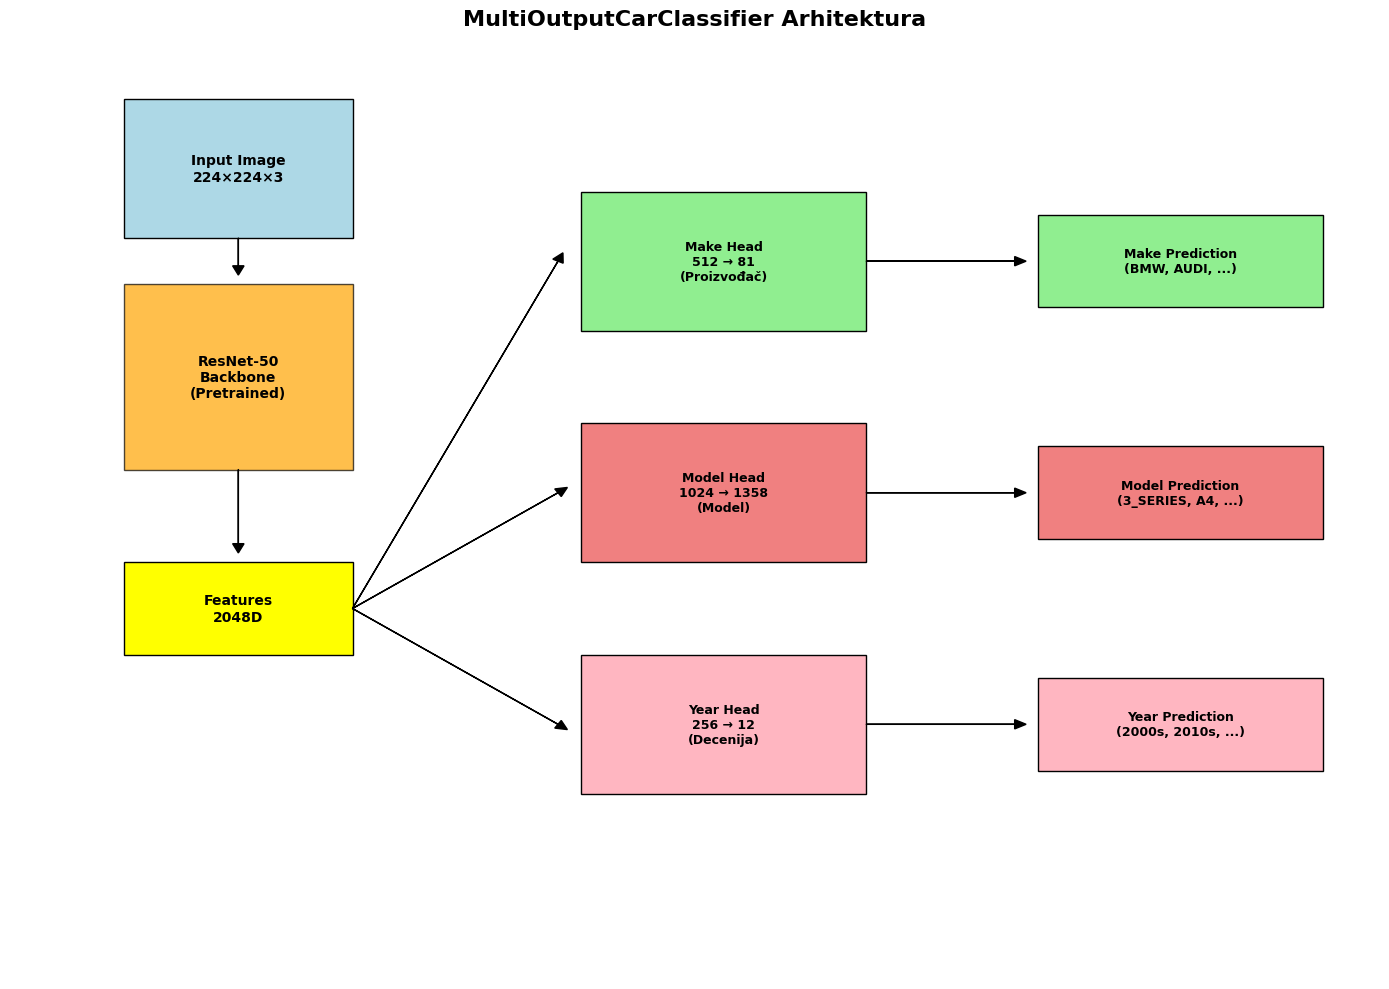

🔄 Tok podataka:
   1. Input slika (224×224×3) → ResNet-50 Backbone
   2. Backbone → Feature vektor (2048D)
   3. Features → 3 odvojena classification head-a
   4. Svaki head → Logits za svoju klasu
   5. Softmax → Verovatnoće za svaki izlaz


In [3]:
# Kreiranje dijagrama arhitekture
fig, ax = plt.subplots(figsize=(14, 10))
ax.set_xlim(0, 12)
ax.set_ylim(0, 10)
ax.axis('off')

# Input slika
ax.add_patch(plt.Rectangle((1, 8), 2, 1.5, facecolor='lightblue', edgecolor='black'))
ax.text(2, 8.75, 'Input Image\n224×224×3', ha='center', va='center', fontsize=10, weight='bold')

# ResNet-50 Backbone
ax.add_patch(plt.Rectangle((1, 5.5), 2, 2, facecolor='orange', edgecolor='black', alpha=0.7))
ax.text(2, 6.5, 'ResNet-50\nBackbone\n(Pretrained)', ha='center', va='center', fontsize=10, weight='bold')

# Feature vector
ax.add_patch(plt.Rectangle((1, 3.5), 2, 1, facecolor='yellow', edgecolor='black'))
ax.text(2, 4, f'Features\n{model.feature_dim}D', ha='center', va='center', fontsize=10, weight='bold')

# Make Head
ax.add_patch(plt.Rectangle((5, 7), 2.5, 1.5, facecolor='lightgreen', edgecolor='black'))
ax.text(6.25, 7.75, f'Make Head\n512 → {num_makes}\n(Proizvođač)', ha='center', va='center', fontsize=9, weight='bold')

# Model Head
ax.add_patch(plt.Rectangle((5, 4.5), 2.5, 1.5, facecolor='lightcoral', edgecolor='black'))
ax.text(6.25, 5.25, f'Model Head\n1024 → {num_models}\n(Model)', ha='center', va='center', fontsize=9, weight='bold')

# Year Head
ax.add_patch(plt.Rectangle((5, 2), 2.5, 1.5, facecolor='lightpink', edgecolor='black'))
ax.text(6.25, 2.75, f'Year Head\n256 → {num_years}\n(Decenija)', ha='center', va='center', fontsize=9, weight='bold')

# Outputs
outputs = [('Make Prediction\n(BMW, AUDI, ...)', 7.75, 'lightgreen'), 
          ('Model Prediction\n(3_SERIES, A4, ...)', 5.25, 'lightcoral'),
          ('Year Prediction\n(2000s, 2010s, ...)', 2.75, 'lightpink')]

for i, (text, y, color) in enumerate(outputs):
    ax.add_patch(plt.Rectangle((9, y-0.5), 2.5, 1, facecolor=color, edgecolor='black'))
    ax.text(10.25, y, text, ha='center', va='center', fontsize=9, weight='bold')

# Strelice
# Input → Backbone
ax.arrow(2, 8, 0, -0.3, head_width=0.1, head_length=0.1, fc='black', ec='black')
# Backbone → Features
ax.arrow(2, 5.5, 0, -0.8, head_width=0.1, head_length=0.1, fc='black', ec='black')
# Features → Heads
for y in [7.75, 5.25, 2.75]:
    ax.arrow(3, 4, 1.8, y-4, head_width=0.1, head_length=0.1, fc='black', ec='black')
# Heads → Outputs
for y in [7.75, 5.25, 2.75]:
    ax.arrow(7.5, y, 1.3, 0, head_width=0.1, head_length=0.1, fc='black', ec='black')

ax.set_title('MultiOutputCarClassifier Arhitektura', fontsize=16, weight='bold', pad=20)
plt.tight_layout()
plt.show()

print("🔄 Tok podataka:")
print("   1. Input slika (224×224×3) → ResNet-50 Backbone")
print(f"   2. Backbone → Feature vektor ({model.feature_dim}D)")
print("   3. Features → 3 odvojena classification head-a")
print("   4. Svaki head → Logits za svoju klasu")
print("   5. Softmax → Verovatnoće za svaki izlaz")

### Loss funkcija - MultiOutputLoss

`MultiOutputLoss` klasa kombinuje loss-ove iz sva tri izlaza u jednu ukupnu loss funkciju. Svaki izlaz ima svoj weight koji kontroliše koliko utiče na finalni loss:

- **make_weight**: Weight za make classification (default 1.0)
- **model_weight**: Weight za model classification (obično veći zbog složenosti)  
- **year_weight**: Weight za year classification (default 1.0)

Klasa takođe podržava **class weights** za svaki izlaz kako bi se kompenzovala nebalansiranost klasa. Ovo je kritično jer neki modeli imaju stotine puta više uzoraka od drugih."

In [ ]:
# MultiOutputLoss implementacija - iz src/model.py

class MultiOutputLoss(nn.Module):
    def __init__(self,
                 make_weight: float = 1.0,
                 model_weight: float = 1.0,
                 year_weight: float = 1.0,
                 make_class_weights: torch.Tensor = None,
                 model_class_weights: torch.Tensor = None,
                 year_class_weights: torch.Tensor = None):
        
        super(MultiOutputLoss, self).__init__()
        self.make_weight = make_weight
        self.model_weight = model_weight
        self.year_weight = year_weight
        
        # Create separate loss functions with class weights
        self.make_loss = nn.CrossEntropyLoss(weight=make_class_weights)
        self.model_loss = nn.CrossEntropyLoss(weight=model_class_weights)
        self.year_loss = nn.CrossEntropyLoss(weight=year_class_weights)
    
    def forward(self, predictions: Dict[str, torch.Tensor], 
                targets: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        
        make_loss = self.make_loss(predictions['make'], targets['make'])
        model_loss = self.model_loss(predictions['model'], targets['model'])
        year_loss = self.year_loss(predictions['year'], targets['year'])
        
        total_loss = (self.make_weight * make_loss +
                      self.model_weight * model_loss +
                      self.year_weight * year_loss)
        
        return {
            'total_loss': total_loss,
            'make_loss': make_loss,
            'model_loss': model_loss,
            'year_loss': year_loss
        }

### Transfer Learning strategija

Model implementira **two-phase training** pristup koji je definisan u specifikaciji projekta:

**Phase 1: Frozen Backbone (5-10 epoha)**
- ResNet-50 backbone se zamrzava (`requires_grad=False`)
- Treniraju se samo classification heads
- Veći learning rate jer heads uče "od nule"
- Cilj: Heads uče da koriste pretrained ImageNet features

**Phase 2: Full Fine-tuning (10-20 epoha)**
- Ceo model se odmrzava (`requires_grad=True`) 
- Manji learning rate da se ne "pokvarе" pretrained weights
- Backbone se prilagođava specifično za automobile
- Cilj: Fine-tuning celokupnog modela za car classification

Ovaj pristup sprečava **katastrofalno zaboravljanje** pretrained weights i omogućava efikasnо iskorišćavanje transfer learning-a."

In [ ]:
# Transfer learning implementacija - iz src/model.py

def freeze_backbone(self):
    \"\"\"Freeze backbone parameters for transfer learning\"\"\"
    for param in self.backbone.parameters():
        param.requires_grad = False

def unfreeze_backbone(self):
    \"\"\"Unfreeze backbone parameters for fine-tuning\"\"\"
    for param in self.backbone.parameters():
        param.requires_grad = True

def get_trainable_parameters(self) -> Tuple[list, list]:
    \"\"\"Get trainable parameters separated by backbone and heads\"\"\"
    backbone_params = list(self.backbone.parameters())
    head_params = (list(self.make_head.parameters()) +
                   list(self.model_head.parameters()) +
                   list(self.year_head.parameters()))
    return backbone_params, head_params

# Upotreba u treniranju:
# Phase 1: model.freeze_backbone(), lr=0.001
# Phase 2: model.unfreeze_backbone(), lr=0.0001

### Handling Class Imbalance

Najveći izazov u našem dataset-u je **ekstremna nebalansiranost klasa**. Iz analize u notebook-u 02 videli smo da:

- Najzastupljeniji model (BMW 1_SERIES): 622 slika
- Najređi modeli: samo 2-3 slike
- **Odnos**: 311:1 između najčešćeg i najređeg

Model koristi **class weights** računanje pomoću sklearn-a da kompenzuje ovaj problem. Funkcija `calculate_class_weights()` koristi 'balanced' strategiju koja daje veće weights retkim klasama:

**Formula**: `weight = n_samples / (n_classes × class_count)`

Ovo znači da retke klase dobijaju proporcionalno veće weights u loss funkciji, primoravajući model da obraća pažnju i na njih umesto da samo predviđa najčešće klase."

In [ ]:
# Class weights kalkulacija - iz src/model.py

def calculate_class_weights(targets: list, num_classes: int) -> torch.Tensor:
    \"\"\"Calculate class weights for imbalanced datasets using sklearn\"\"\"
    from sklearn.utils.class_weight import compute_class_weight
    import numpy as np
    
    # Get unique classes and compute weights
    unique_classes = np.unique(targets)
    class_weights = compute_class_weight(
        'balanced',
        classes=unique_classes,
        y=targets
    )
    
    # Create weight tensor for all classes
    weights = torch.ones(num_classes, dtype=torch.float32)
    for i, class_idx in enumerate(unique_classes):
        if class_idx < num_classes:
            weights[class_idx] = class_weights[i]
    
    return weights

# Upotreba:
# model_weights = calculate_class_weights(model_targets, num_models)
# loss_fn = MultiOutputLoss(model_class_weights=model_weights)

### Zaključak o arhitekturi

**MultiOutputCarClassifier** je dizajniran da reši izazove multi-output klasifikacije automobila:

#### ✅ Prednosti arhitekture:
- **Shared backbone**: ResNet-50 pretrained na ImageNet daje dobre feature representations
- **Specialized heads**: Različite veličine head-ova prilagođene broju klasa
- **Transfer learning**: Two-phase training za efikasno iskorišćavanje pretrained weights
- **Class imbalance handling**: Weighted loss za kompenzaciju nebalansiranosti
- **Dropout regularization**: Sprečava overfitting u classification heads

#### 🎯 Ključne karakteristike:
- **Parametri**: ~26M ukupno (23M backbone + 3M heads)
- **Input**: 224×224×3 RGB slike
- **Output**: 3 odvojena logit vektora za make/model/year
- **Loss**: Weighted kombinacija CrossEntropyLoss za svaki izlaz

#### 🔄 Sledeći korak:
Pokušaj treniranja ovog modela i analiza problema koji se pojavljuju.